## CUSTOMER CHURN PREDICTION FOR A BANK ##

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading & First Look](#Data-Loading)
3. [Data Cleaning & Preprocessing](#Data-Cleaning)
4. [Exploratory Data Analysis (EDA)](#EDA)
5. [Feature Engineering](#Feature-Engineering)
6. [Handling Class Imbalance](#Class-Imbalance)
7. [Model Building & Evaluation](#Model-Building)
8. [Model Interpretation](#Model-Interpretation)
9. [Conclusion & Business Recommendations](#Conclusion)

<a id='Introduction'></a>
## 1. Introduction

**What is Customer Churn?**
Customer churn (or customer attrition) happens when a client or customer stops doing business with a company. For a bank, this is when a customer closes their accounts with the bank and stops using their services altogether

**Why is predicting churn important?**
- **Acquiring a new customer** is anywhere from **5 to 25 times more expensive** than retaining an existing one.
- A **5% increase in customer retention** can increase profitability by **25% to 95%**.
- By predicting who is likely to churn, a bank can proactively engage those customers with special offers, better support, or targeted marketing, ultimately saving revenue.

**Project Overview:**
In this project, we will use machine learning to analyze customer data and build a model that predicts the likelihood of a customer leaving the bank. We will use a mock dataset collected from banking institutions

**Project Goals**

Our main objectives are:
1.  **Identify** the key factors that lead to customer churn.
2.  **Build a predictive model** that accurately flags customers at high risk of churning.
3.  **Translate** our model's findings into **actionable business strategies** to help reduce the churn rate.

In [3]:
# import all the necessary tools and libraries for our analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
print("All libraries imported successfully!")

All libraries imported successfully!


<a id='Data-Loading & First-Look'></a>
## 2. Data Loading & First Look

In [6]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

Current Working Directory: c:\Users\betom\AppData\Local\Programs\Microsoft VS Code


In [8]:
# Define the new directory path
new_directory = "C:/Users/betom/OneDrive - The University of Colorado Denver/Personal Projects" 
# Change the current working directory to the new directory
os.chdir(new_directory)
print(f"New Working Directory: {os.getcwd()}")

New Working Directory: C:\Users\betom\OneDrive - The University of Colorado Denver\Personal Projects


In [ ]:
# Load the data from a CSV file into a Pandas DataFrame
df = pd.read_csv('Churn_Modelling.csv')

# Check the shape: (Number of Rows, Number of Columns)
print("Dataset Dimensions:", df.shape)
print("\n")

# Display the first 5 rows
print("First Look at the Data:")
df.head()

Dataset Dimensions: (10000, 14)


First Look at the Data:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
# Get a concise summary of the DataFrame.
# This shows us the column names, how many non-null values there are, and the data type (e.g., object, int64, float64).
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Initial Observations:**
- We have **10000 customers** (10001 rows) and **13 features** (14 columns) about them.
- The target variable is the **`Exited`** column, which tells us if the customer left (`1`) or stayed (`0`).
- Most columns are numeric (`int64`, `float64`), like `Age`, `Tenure` (how long they've been a customer), `Balance` and `EstimatedSalary`. meaning they contain categories like 'Yes', 'No', 'Fiber optic', etc.
- A few columns are categorical like `Geography` and `Gender` are listed as `object`, which is suspicious—it should be a number. We'll need to fix this.
- There are no missing values in any of the columns.

<a id='Data-Cleaning'></a>
## 3. Data Cleaning & Preprocessing

Distribution of Exited Values:
Exited
0    7963
1    2037
Name: count, dtype: int64


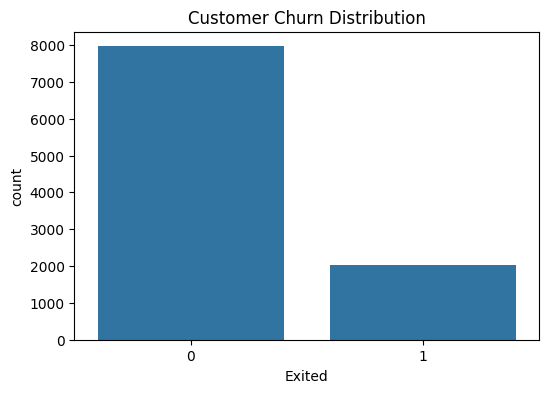

In [14]:
# Examine our target variable: 'Exited'
print("Distribution of Exited Values:")
print(df['Exited'].value_counts())

# Visualize the distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df)
plt.title('Customer Churn Distribution')
plt.show()


**Observation:**
- The dataset is **imbalanced**. There are far more customers who did **not churn** (`0`) than those who did (`1`).
- This is a common real-world scenario. We will have to account for this later so our model doesn't just learn to always predict "No Churn".

In [17]:
# The 'RowNumber','CustomerID', and "Surname' don't help us predict churn patterns.
# We remove them so our model doesn't get confused by it.
df.drop(columns=['RowNumber','CustomerId', 'Surname'], axis=1, inplace=True)
print("'RowNumber,'CustomerID','Surname' columns dropped.")

'RowNumber,'CustomerID','Surname' columns dropped.


## 4. Exploratory Data Analysis

Summary Statistics for Numerical Features:
        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

       EstimatedSalary  
count     10000.000000  
mean     100090.239881  
std       57510.492818  
min          11.580000  
25%       51002.110000  
50%      100193.915000  
75%      149388.247500  
max      199992.480000  


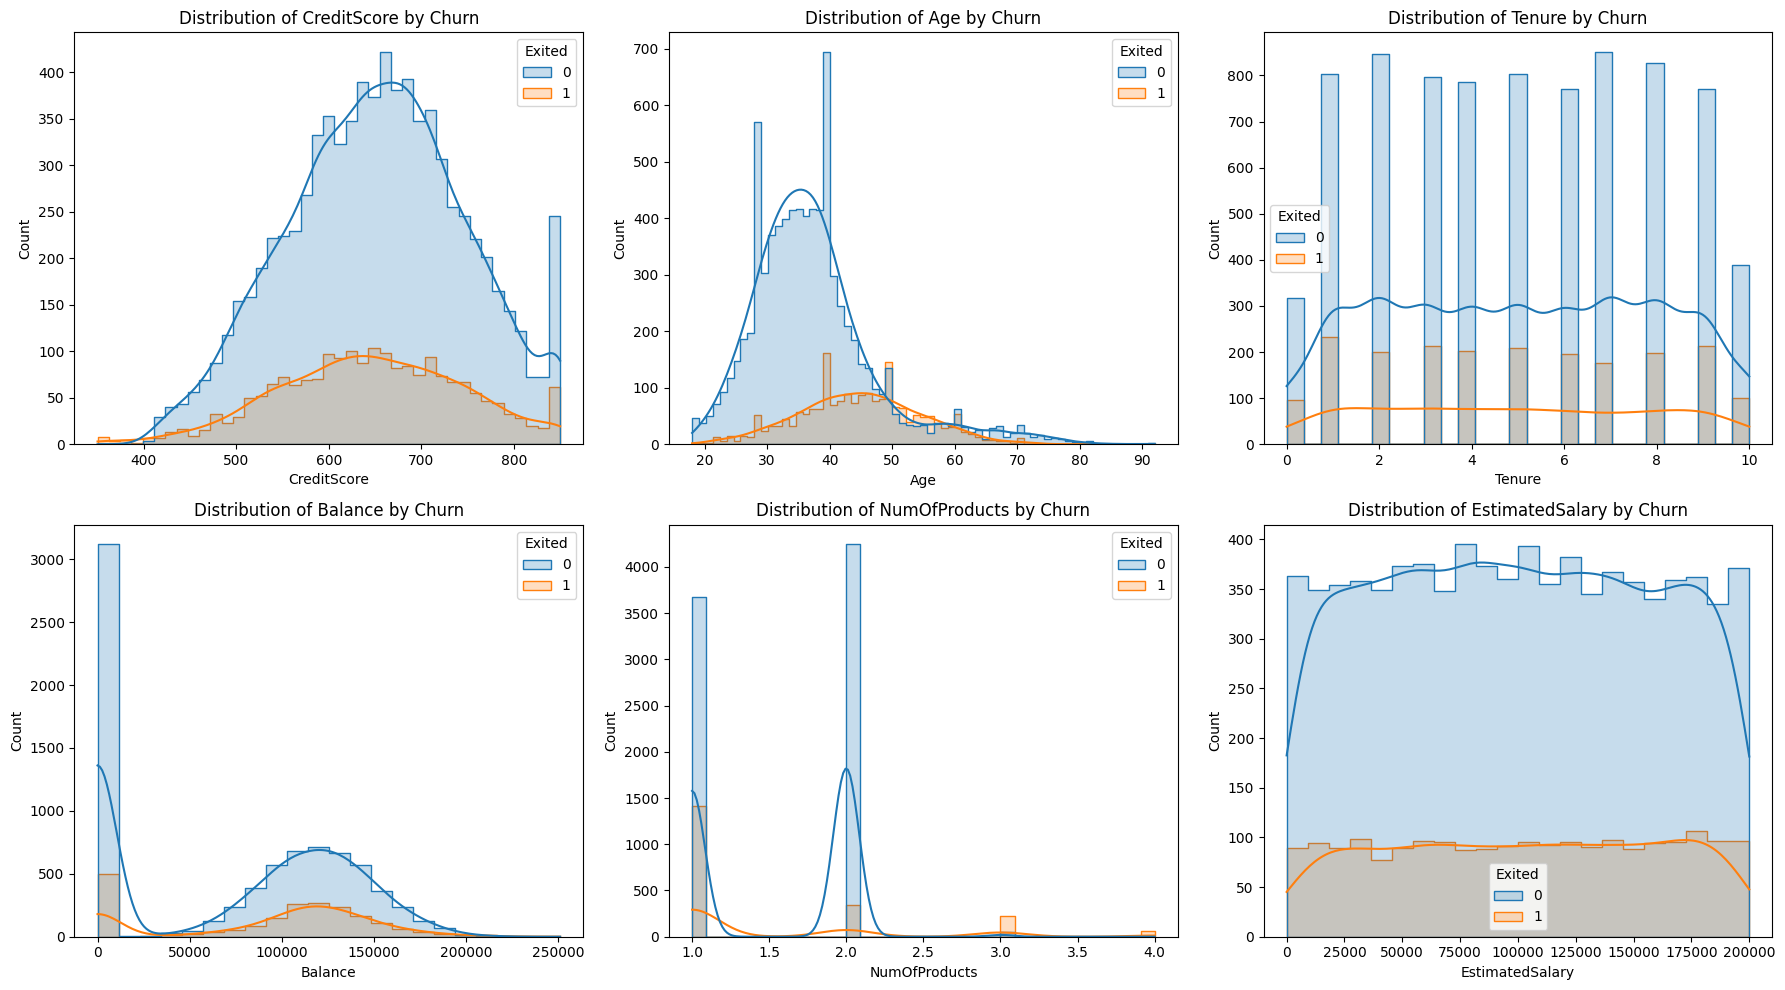

In [24]:
# First, let's look at the numerical features: credit score, age, tenure, balance, estimated salary
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
print("Summary Statistics for Numerical Features:")
print(df[numeric_features].describe())

# Let's see how these numerical features relate to exit rate.
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes_list = [axes[0, 0], axes[0, 1], axes[0, 2], 
             axes[1, 0], axes[1, 1], axes[1, 2]]

for i, col in enumerate(numeric_features):
    # Create a histogram with two distributions (Churn=Yes and Churn=No) overlaid
    sns.histplot(data=df, x=col, hue='Exited', kde=True, ax=axes_list[i], element='step', stat='count', common_norm=False)
    axes_list[i].set_title(f'Distribution of {col} by Churn')
    axes_list[i].set_xlabel(col)

plt.tight_layout()
plt.show()

**Insights from Numerical Features:**
- **`Age`**: **Older customers are more likely to churn**. This could be due to life changes, better offers from competitors, or dissatisfaction with digital services.
- **`Balance`**: Customers with **higher balances churn more**. This is a major risk; losing these customers hurts the bank's assets. They might be more financially savvy and willing to move for a better offer.
- **`NumOfProducts`**: Customers with only **1 product churn a lot**, while those with 2 are less likely. Those with 3 or 4 are very loyal! This suggests a "sweet spot" for customer engagement.
- **`CreditScore`**, **`Tenure`**, **`EstimatedSalary`**: The distributions look fairly similar between groups. These might be weaker predictors on their own.

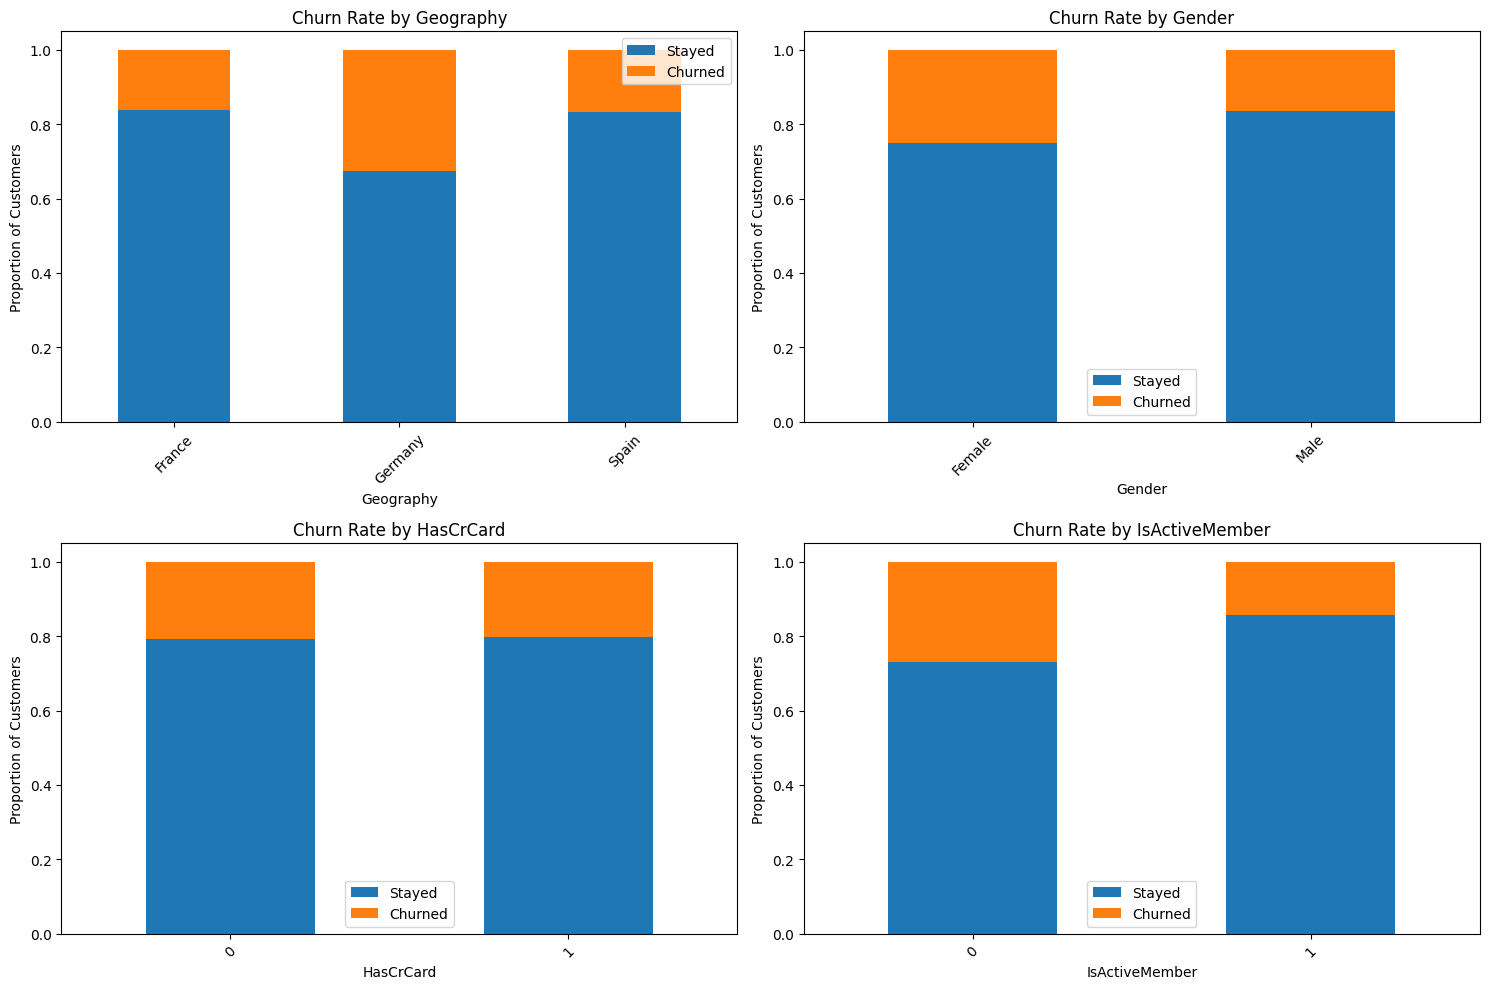

In [25]:
categoric_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
# Now, let's analyze categorical features using proportional stacked bar charts.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(categoric_features):
    pd.crosstab(df[feature], df['Exited'], normalize='index').plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Churn Rate by {feature}')
    axes[i].set_ylabel('Proportion of Customers')
    axes[i].legend(['Stayed', 'Churned'])
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Key Insights from Categorical Features:**
- **`Geography`**: Customers from **Germany have a much higher churn rate** (~32%) than those from France or Spain. This is a critical finding and could point to issues with the bank's competitive position or customer service in Germany.
- **`Gender`**: **Female customers churn at a higher rate** than male customers. The bank's marketing or product offerings might not be resonating equally.
- **`IsActiveMember`**: This is one of the strongest signals! **Inactive members are far more likely to churn**. This makes intuitive sense – a lack of engagement is a strong precursor to leaving.
- **`HasCrCard`**: Whether the customer owns a credit card or not doesn't seem to have a major impact on churn rates.

## 5. Feature Engineering

In [26]:
# Prepare our target variable (y) and features (X)
y = df['Exited']
X = df.drop('Exited', axis=1)

# One-Hot Encode the categorical features
# We use drop_first=True to avoid the "dummy variable trap" (multicollinearity)
X_encoded = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)

print(f"Original features: {X.shape[1]}")
print(f"Features after encoding: {X_encoded.shape[1]}")
X_encoded.head()

Original features: 10
Features after encoding: 11


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,True,False


## 6. Handling Class Imbalance

If we train a model on the class imbalance, it might become biased toward predicting the majority class ("No Churn"). We need to fix this.

In [29]:
pip install imbalanced-learn

   ---------------------------------------- 0.0/240.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/240.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/240.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/240.0 kB 262.6 kB/s eta 0:00:01
   ----------- --------------------------- 71.7/240.0 kB 435.7 kB/s eta 0:00:01
   ---------------------------------------- 240.0/240.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
# First, we split our data into a Training Set (to build the model) and a Test Set (to evaluate it fairly).
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
# `stratify=y` ensures the train/test split has the same proportion of churn as the original data.
# `random_state=42` ensures we get the same split every time, which is good for reproducibility.

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Churn distribution in Training set:", pd.Series(y_train).value_counts().to_dict())

Training set size: (8000, 11)
Test set size: (2000, 11)
Churn distribution in Training set: {0: 6370, 1: 1630}


In [33]:
# We use a technique called SMOTE to balance our training data.
# SMOTE creates synthetic examples of the minority class (Churn) instead of just copying them.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution AFTER applying SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution AFTER applying SMOTE:
Exited
1    6370
0    6370
Name: count, dtype: int64


In [34]:
# It's generally a good practice to scale numerical features so they are on a similar range.
# This helps models like Logistic Regression perform better.
scaler = StandardScaler()
# We fit the scaler on the training data and then apply that same transformation to the test data.
X_train_smote[numeric_features] = scaler.fit_transform(X_train_smote[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
print("Numerical features have been scaled.")

Numerical features have been scaled.


## 7. Model Building

In [35]:
# We'll test three different algorithms to see which works best.
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss') # eval_metric is needed for XGBoost
}

# We'll store the results for each model in this dictionary.
results = {}

# Loop through each model, train it, make predictions, and evaluate.
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # 1. Train the model on the balanced training data
    model.fit(X_train_smote, y_train_smote)
    
    # 2. Use the model to make predictions on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Get the probability of churning (class 1)
    
    # 3. Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # 4. Print a detailed report
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # 5. Store the results for later comparison
    results[name] = {'model': model, 'accuracy': accuracy, 'roc_auc': roc_auc, 'predictions': y_pred, 'probabilities': y_prob}


--- Training Logistic Regression ---
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1593
           1       0.39      0.58      0.47       407

    accuracy                           0.73      2000
   macro avg       0.64      0.68      0.65      2000
weighted avg       0.78      0.73      0.75      2000

ROC-AUC Score: 0.7313

--- Training Random Forest ---
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1593
           1       0.55      0.63      0.58       407

    accuracy                           0.82      2000
   macro avg       0.72      0.75      0.73      2000
weighted avg       0.83      0.82      0.82      2000

ROC-AUC Score: 0.8392

--- Training XGBoost ---
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1593
           1       0.54      0.64      0.59       407

    accuracy                           0.8

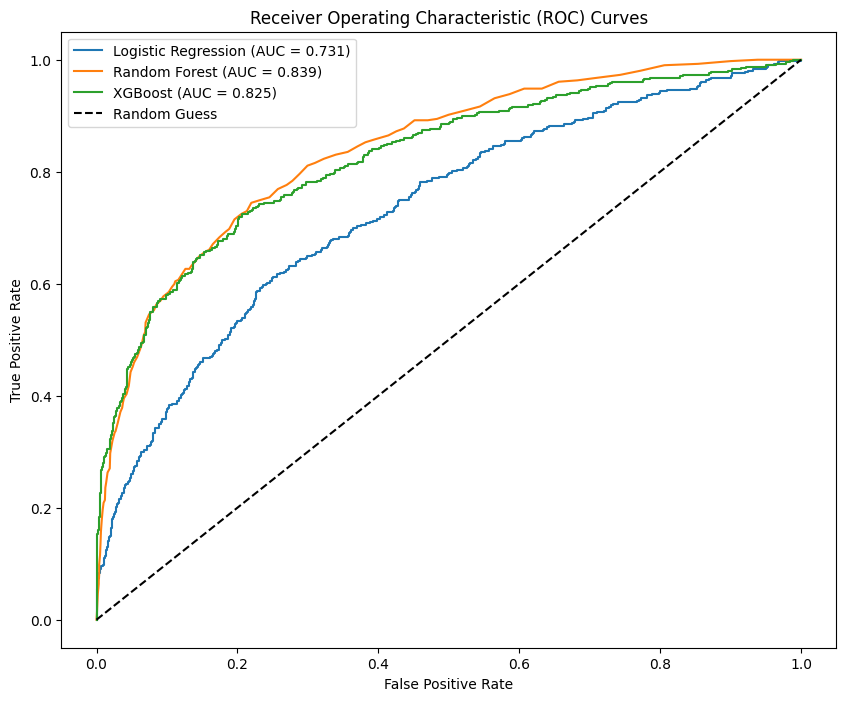

In [36]:
# Let's visualize the performance using ROC curves.
# The ROC curve shows the trade-off between the True Positive Rate and False Positive Rate.
# A model that is closer to the top-left corner is better. The dashed line represents random guessing.

plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {res["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

**Model Evaluation Summary:**
- **Logistic Regression**: A good baseline model.
- **XGBoost**: More powerful model
- **Random Forest**: The best performing model. It might be good at capturing complex relationships.

**Random Forest model performed the best**, and we will use it for interpretation.

## 8. Model Interpretation

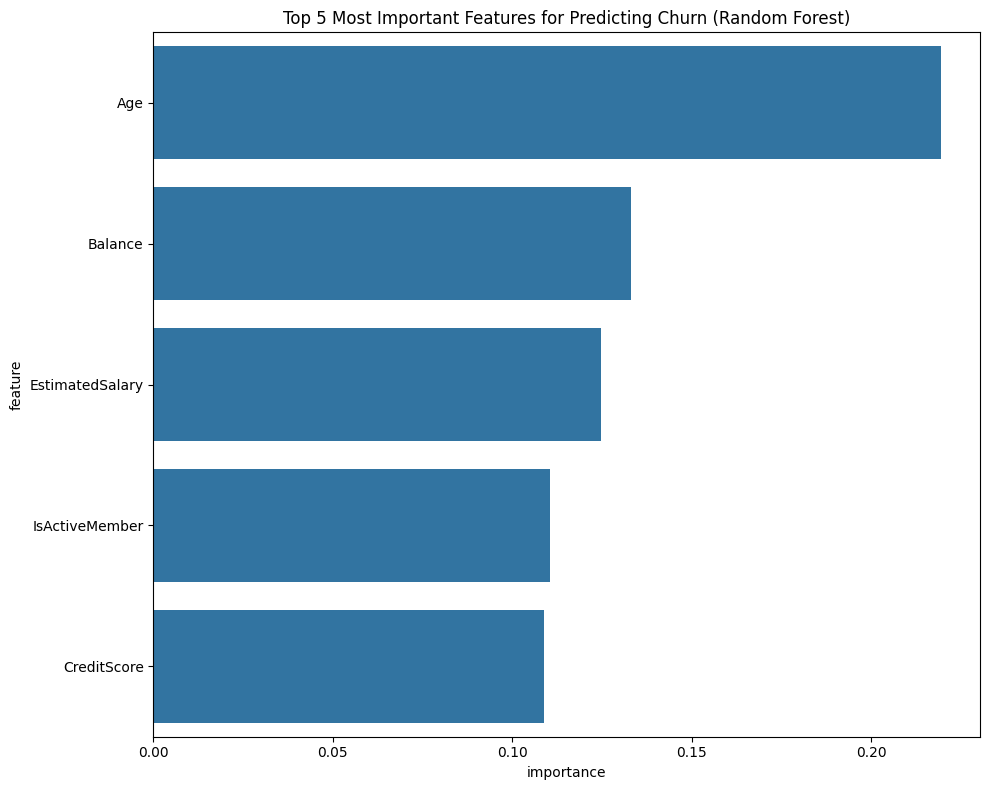

In [38]:
# Let's analyze our best model
best_model = results['Random Forest']['model']

# 1. Feature Importance - What features did the model find most useful?
feature_importance = pd.DataFrame({
    'feature': X_train_smote.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(5)) # Show top 5 features
plt.title('Top 5 Most Important Features for Predicting Churn (Random Forest)')
plt.tight_layout()
plt.show()

In [40]:
pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   -- ------------------------------------ 30.7/545.3 kB 660.6 kB/s eta 0:00:01
   ----- --------------------------------- 71.7/545.3 kB 787.7 kB/s eta 0:00:01
   --------------- ------------------------ 204.8/545.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------  542.7/545.3 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------- -------------------------- 1.0/2.8 MB 20.5 MB/s eta 0:00:01
   -------------------------------- ------- 2.3/2.8 MB 20.9 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 19.7 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 19.7 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 19.7 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 19.7 MB/s eta 0:00:0

c:\Users\betom\anaconda3\envs\rasterio\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


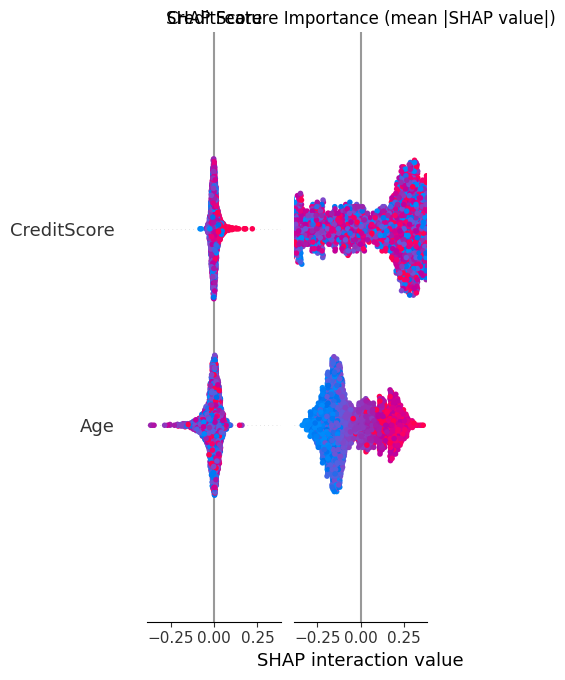

In [41]:
# 2. SHAP (SHapley Additive exPlanations) - A unified measure of feature importance.
# This is a more advanced and accurate way to see how each feature pushes the model's prediction.
import shap
# Create a SHAP explainer for our model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test set (this can take a minute)
shap_values = explainer.shap_values(X_test)

# Summary Plot (Bar)
shap.summary_plot(shap_values, X_test, feature_names=X_train_smote.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (mean |SHAP value|)")
plt.show()

**Credit Score** and **Age** are the top 2 most important features for predicting churn. Higher age pushes prediction towards exiting. This confirms the EDA finding that older customers are more likely to leave. And lower credit scores seem to push predictions toward churn.

## 9. Conclusions and Business Recommendations

### **Summary of Findings**

Our analysis reveals a clear profile of the high-risk customer. The most important factors driving exiting rate are:

1.  **Geography:** Being a customer in **Germany** is the single biggest risk factor.
2.  **Age:** **Older customers** are significantly more likely to leave.
3.  **Engagement:** Customers who are **inactive members** (`IsActiveMember = 0`) are highly likely to churn.
4.  **Product Holding:** There is a **"Goldilocks Zone" for products**. Customers with only 1 product are at high risk, while those with 3, 4 are very loyal.
5.  **Credit Score:** Customers with lower credit scores are also at a higher risk of leaving
### **Actionable Business Recommendations**

1.  **Launch a Targeted German Retention Program:**
    - **Action:** Immediately investigate the root cause of churn in Germany. Is it customer service, competitor offers, or product fit? Launch a dedicated campaign for German customers, potentially offering personalized financial reviews or exclusive products.

2.  **Develop an "Engagement Reactivation" Campaign:**
    - **Action:** Identify customers marked as `IsActiveMember = 0`. Target them with re-engagement emails, notifications about new features, or small incentives to log into their app/website. Reactivation is a powerful tool against churn.

3.  **Create Life-Stage Packages for Older Customers:**
    - **Action:** Customers over ~45 are at high risk. Develop and market products bundles tailored to their needs (e.g., retirement planning, wealth management, health insurance partnerships). Proactive outreach from a financial advisor could be very effective.

4.  **Improve Product Bundling and Cross-Selling:**
    - **Action:** The goal for at-risk customers with only 1 product should be to get them to a 2-product bundle. Create irresistible, simple bundles (e.g., "Get a credit card with no fee for a year when you maintain a Balance over $X"). For customers with 3+ products, ensure they are not overwhelmed and receive premium support.

5.  **Implement a High-Value Customer Care Program:**
    - **Action:** For customers with low credit score, implement credit health programs might help retain customers. Proactive, personalized service is key. They should feel valued and heard.

**Expected Outcome:** By focusing these strategies on the customers identified by our model as high-risk, the bank can efficiently allocate its retention budget and potentially reduce churn by a significant percentage, directly protecting its customer base and bottom line.